# Load libraries 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates

# SPEDAS API
# make sure to use the local spedas
sys.path.insert(0,"/Users/nokni/work/MHDTurbPy/pyspedas")
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """
#cd TurbPy
sys.path.insert(1,'/Users/nokni/work/MHDTurbPy')
import calc_diagnostics as calc
import TurbPy as turb
import functions as func

# Bettet figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True


This unreleased version of SpacePy is not supported by the SpacePy team.


# Download data
    - SCAM for PSP does not work great because it doesnt download all the files needed (Fix!)

In [2]:
# Choose PSP or SolO
sc                      = 0                               # PSP:0, SolO:1

# If you only need to download 1 interval (dates wont matter if only_one_interval=0)
only_one_interval       = 1                               # If you only want to check one interval
starting_date           = '2018-11-03 08:06:00'           # Define starting and ending date of the interval
ending_date             = '2018-11-04 08:06:00'

# on the other hand if you have a list of intervals
load_path        = '/Users/nokni/work/MHDTurbPy/example/' # In case you have multiple days you want to download ()



choose_working_dir      = '/Users/nokni/work/sc_data/'    # Working dir. Usually where you save raw data (a psp_data, and/or solar_orbiter_data folder will be created)
save_path               = 'final_intervals/'              # This will be connected with the parent of load_path

#User defined parameters
subtract_rol_mean       = 1                               # To estimate fluctuations of mag, vel field
gap_time_threshold      = 5                               # Threshold for large gaps (units of seconds)
estimate_PSD            = 0                               # Estimate magentic field powes spectral density (keep false)
estimate_PSD_V          = 0                               # Estimate velocity field powes spectral density (keep false)
mag_resolution          = 10                              # Resample magnetic field timeseries in [ms] (at best, usually lower resolution depending on the interval)
high_res_mag            = 0                               # Use high resol or low resolution magnetic field data ( Choose either 1 or 0 respectively)
in_RTN                  = 1                               # RTN or spacecraft frame ( We will usually use RTN)
f_min_spec              = 2*1e-3                          # Integrate over [f_min_spec, f_max_spec]to estimate σc, σr 
f_max_spec              = 1e-2                            #
step                    = '12H'                           # Move starting point by step (in Hours)
duration                = '24H'                           # Duration of interval (in Hours)
settings                =  {
                            'particle_mode'      : 'empirical',                     
                            'final_freq'         : '5s',
                            'use_hampel'         : False,
                            'interpolate_qtn'    : True,
                            'interpolate_rolling': True,
                            'verbose'            : False,
                            'must_have_qtn'      : False
                            } 
credentials              =  { 'psp':
                                  {
                                     'fields': {'username': 'none', 'password': 'none'},
                                     'sweap' : {'username': 'none', 'password': 'none'}
                                  }
                              }

# Change to to specified working dir
os.chdir(choose_working_dir)

if only_one_interval:
    df                      =  pd.DataFrame(    index = np.arange(1),
                                                data  = { 'Start' : pd.Timestamp(starting_date), 
                                                          'End'   : pd.Timestamp(ending_date)})
else:
    df                      =  pd.read_pickle(load_path)

# Define final path
final_path              =  Path(load_path).joinpath(save_path)

# Run main loop
for ok in range(0,len(df)):
    # Print progress
    func.progress_bar(ok, len(df))

    t0 = df['Start'][ok]
    t1 = df['End'][ok]

    """Setup for main function"""
    tstarts, tends, tfmt, path0, settings   = calc.set_up_main_loop(final_path, settings, only_one_interval,t0, t1, step, duration, sc)

    # Load dist_df of SolO. Stupid way to do it fix later!!
    dist_df            = pd.read_pickle(str(Path(load_path).joinpath("ephem_data").joinpath("SolO_ephem.pkl")))

    """ Now run main for loop! """
    for i1 in range(len(tstarts)):
        start_time  = tstarts[i1]
        end_time    = tends[i1]
        
        # Define folder name
        foldername  = "%s_%s_sc_%d" %(str(start_time.strftime(tfmt)), str(end_time.strftime(tfmt)), 0)

        if not os.path.exists(path0.joinpath(foldername)):
            # Running the main function
            big_gaps, flag_good, final, general, sig_c_sig_r_timeseries = calc.final_func(
                                                                                          estimate_PSD_V   , 
                                                                                          subtract_rol_mean, 
                                                                                          settings,dist_df , 
                                                                                          start_time       ,
                                                                                          end_time         ,
                                                                                          f_min_spec       , 
                                                                                          f_max_spec       , 
                                                                                          estimate_PSD     , 
                                                                                          sc               , 
                                                                                          credentials      ,
                                                                                          high_res_mag     ,
                                                                                          in_RTN           ,
                                                                                          mag_resolution   , 
                                                                                          gap_time_threshold 
                                                                                         )
            if flag_good == 1:# (save...)

                if os.path.exists(path0.joinpath(foldername)):
                    print("%d out of %d finished" %(i1, len(df)))
                    continue
                try:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)

                    pickle.dump(final,open(path0.joinpath(foldername).joinpath("final_data.pkl"),'wb'))
                    pickle.dump(general,open(path0.joinpath(foldername).joinpath("general.pkl"),'wb'))

                except:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)
                    print("%s - %s failed!" %(i1, len(tstarts)))

                print("%d out of %d finished" %(i1, len(tstarts)))
            else:
                os.makedirs(path0.joinpath(foldername), exist_ok=True)
                print("%s - %s failed!" %(i1, len(tstarts)))            

19-Jan-23 01:22:54: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l3/sqtn_rfs_v1v2/2018/


Completed 0.0
Using LEVEL=L3


19-Jan-23 01:22:55: File is current: psp_data/fields/l3/sqtn_rfs_v1v2/2018/psp_fld_l3_sqtn_rfs_v1v2_20181103_v1.0.cdf
19-Jan-23 01:22:55: File is current: psp_data/fields/l3/sqtn_rfs_v1v2/2018/psp_fld_l3_sqtn_rfs_v1v2_20181104_v1.0.cdf
19-Jan-23 01:22:56: Time clip was applied to: electron_density
19-Jan-23 01:22:56: Time clip was applied to: electron_core_temperature
19-Jan-23 01:22:56: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
19-Jan-23 01:22:56: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018110306_v02.cdf
19-Jan-23 01:22:57: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018110312_v02.cdf
19-Jan-23 01:22:57: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018110318_v02.cdf
19-Jan-23 01:22:57: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018110400_v02.cdf
19-Jan-23 01:22:58: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_201

Using LEVEL=L3


19-Jan-23 01:23:56: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
19-Jan-23 01:23:56: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
19-Jan-23 01:23:58: Time clip was applied to: psp_spc_np_moment
19-Jan-23 01:23:58: Time clip was applied to: psp_spc_wp_moment
19-Jan-23 01:23:58: Time clip was applied to: psp_spc_vp_moment_RTN
19-Jan-23 01:23:58: Time clip was applied to: psp_spc_vp_moment_SC
19-Jan-23 01:23:58: Time clip was applied to: psp_spc_sc_pos_HCI
19-Jan-23 01:23:59: Time clip was applied to: psp_spc_sc_vel_HCI
19-Jan-23 01:23:59: Time clip was applied to: psp_spc_carr_latitude
19-Jan-23 01:23:59: Time clip was applied to: psp_spc_carr_longitude
19-Jan-23 01:23:59: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2018/
19-Jan-23 01:24:00: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2018/psp_swp_spi_sf00_l3_mom_20181103_v04.cdf
19-Jan-23 01:24:00: File i

final resol 875ms


19-Jan-23 01:24:03: /var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_6966/1961198343.py:106: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/nokni/work/MHDTurbPy/example/final_intervals/2018-11-03_08-06-00_2018-11-04_08-06-00_sc_0/final_data.pkl'>
  pickle.dump(final,open(path0.joinpath(foldername).joinpath("final_data.pkl"),'wb'))

19-Jan-23 01:24:03: /var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_6966/1961198343.py:107: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/nokni/work/MHDTurbPy/example/final_intervals/2018-11-03_08-06-00_2018-11-04_08-06-00_sc_0/general.pkl'>
  pickle.dump(general,open(path0.joinpath(foldername).joinpath("general.pkl"),'wb'))



0 out of 1 finished


# Visualize data

19-Jan-23 01:59:00: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


final resol 60000ms


19-Jan-23 01:59:03: /Users/nokni/work/MHDTurbPy/functions.py:1944: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



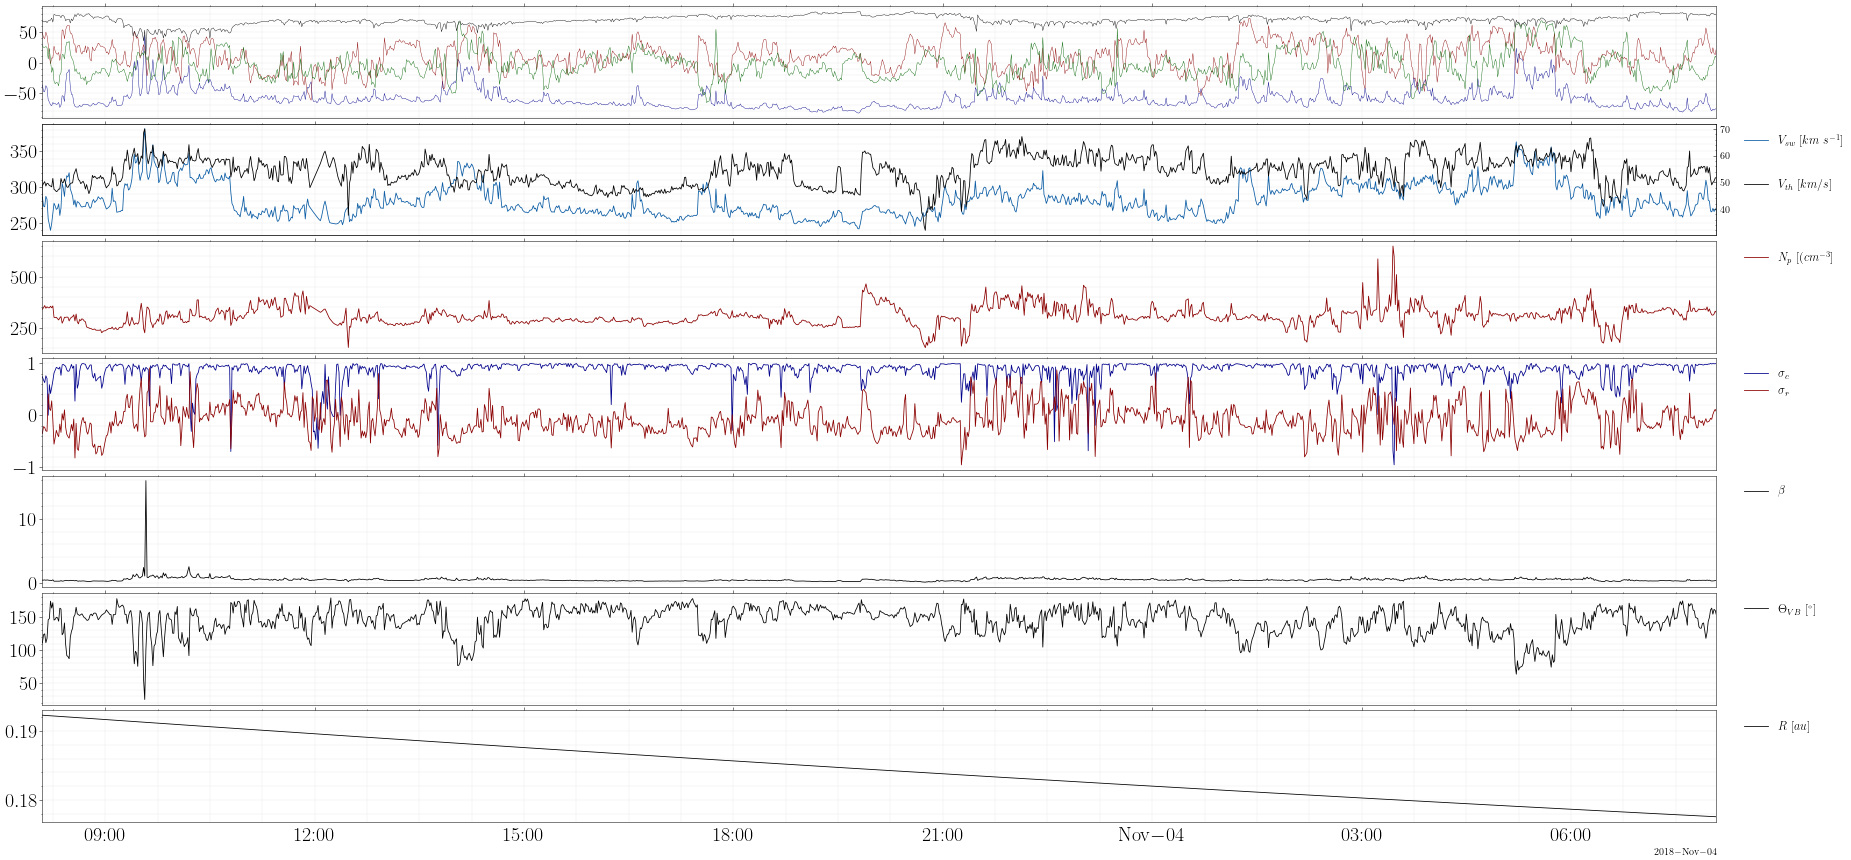

In [43]:
# user defined parameters
size              = 21                                    # labels etc
inset_f_size      = 20                                    # Not needed 
numb_subplots     = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/example' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures
res_rate          = 60                                    # Resample timeseries [seconds]


func.visualize_downloaded_intervals(
                                  sc,
                                  final['Par']['V_resampled'],
                                  final['Mag']['B_resampled'],
                                  res_rate,
                                  my_dir,
                                  format_2_return ="%Y_%m_%d",  #
                                  size             = 21,
                                  inset_f_size     = 20,
                                  numb_subplots    = 7
                                 )

 